In [1]:
#importing libraries
import os #library for 
import gc #garbage collector library for saving RAM
import pandas as pd #pandas dataframe library
import numpy as np #numpy array library
import matplotlib.pyplot as plt #library for plotting 
import seaborn as sns #seaborn library for visualization
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import scipy.stats as stats
import sklearn as sk
from scipy import sparse
from sklearn.model_selection import train_test_split #library for spliting dataset
from sklearn.metrics import mean_squared_error #function for checking model accuracy
from sklearn.neighbors import NearestNeighbors #KNN function for checking the nearest neighbors
from sklearn.model_selection import GridSearchCV #Gridsearch function for hyperparameter tuning
from scipy.sparse import csr_matrix #Function to convert dataframe to a sparse matrix
from sklearn.metrics.pairwise import cosine_similarity #function to measure the distance between vectors
from sklearn.metrics import mean_absolute_error #function for checking model accuracy
from sklearn.metrics import r2_score #function for checking model accuracy
from scipy.linalg import svd #function for SVD

# **<span style='color:#F76241'>|</span>Systems Development for Marketing </b>**
### Building a Recommended System for Netflix Dataset - David Andrew - 500903075

## <b>1<span style='color:#F76241'>|</span> Introduction

**<span style='color:#F76241'>Main Research question:</span>** </br>
How can customer experience be improved by recommending Netflix Movies that they are likely to enjoy?? </br>

</br>**<span style='color:#F76241'>Sub Research questions:</span>** </br>
What are the most effective algorithms and techniques for building a recommender system for the Netflix users ? <br>

What are the most effective algorithms and techniques for predicting user ratings based on the Netflix Prize dataset? </br>

How can we evaluate the accuracy and effectiveness of different recommender system algorithms using the Netflix Prize dataset? </br>

How Similar are the users in terms of their feeling towards a particular movie</br>


</div>

### <b>1.1<span style='color:#F76241'>|</span> Data Preparation

The Netflix Prize dataset is a large dataset of movie ratings that was released by Netflix in 2006. The dataset consists of about 100,000,000 ratings for 17,770 movies given by 480,189 users1. Each rating in the training dataset consists of four entries: user, movie, date of grade, grade. Users and movies are represented with integer IDs, while ratings range from 1 to 51. The goal of the Netflix Prize was to develop a recommendation algorithm that could predict user ratings for movies and TV shows with greater accuracy than Netflix’s existing algorithm.

In [2]:
#Merging the training dataset, code adopted from https://www.kaggle.com/code/elemento/netflix-prizedata
if not os.path.isfile('C:/Users/User/Dropbox/PC/Desktop/Masters DDB/Sysem development for marketing/Recsys Assignment/data.csv'):
    # Create a file 'data.csv' before reading it
    # Read all the files in the dataset and store them in one big file ('data.csv')
    # We're reading from each of the four files and appending each rating to a global file 'data.csv'
    
    data= open('data.csv', mode='w')
    
    row = []
    files = [
        'C:/Users/User/Dropbox/PC/Desktop/Masters DDB/Sysem development for marketing/Recsys Assignment/combined_data_1.txt',
        'C:/Users/User/Dropbox/PC/Desktop/Masters DDB/Sysem development for marketing/Recsys Assignment/combined_data_2.txt', 
        'C:/Users/User/Dropbox/PC/Desktop/Masters DDB/Sysem development for marketing/Recsys Assignment/combined_data_3.txt', 
        'C:/Users/User/Dropbox/PC/Desktop/Masters DDB/Sysem development for marketing/Recsys Assignment/combined_data_4.txt']
    for file in files:
        print("Reading ratings from {}\n".format(file))
        with open(file) as f:
            for line in f: 
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '') #this code is to remove the colon at the end of the line
                else:
                    row = [x for x in line.split(',')] #this code is to split the line into a list
                    row.insert(0, movie_id) #this code is to insert the movie id at the beginning of the list
                    data.write(','.join(row)) #this code is to join the list into a string
                    data.write('\n') #this code is to add a new line
    data.close()

In [3]:
# print("Creating the dataframe from data.csv file")
df1 = pd.read_csv('C:/Users/User/Dropbox/PC/Desktop/Masters DDB/Sysem development for marketing/Recsys Assignment/data.csv', sep=',', 
    names=['MovieID', 'userID', 'rating', 'rating_date'])
df1.rating_date = pd.to_datetime(df1.rating_date)

In [4]:
#checking the shape of df1
print(df1.shape)

(100480507, 4)


In [5]:
#reading the other datasets
df2 = pd.read_csv('C:/Users/User/Dropbox/PC/Desktop/Masters DDB/Sysem development for marketing/Recsys Assignment/movie_titles.csv', sep=';')
qualifying = pd.read_csv('C:/Users/User/Dropbox/PC/Desktop/Masters DDB/Sysem development for marketing/Recsys Assignment/qualifying.txt', sep=',')
probe = pd.read_csv('C:/Users/User/Dropbox/PC/Desktop/Masters DDB/Sysem development for marketing/Recsys Assignment/probe.txt', sep=',')

In [6]:
#adding the 'Year of release' and 'Title' columns to the df1 dataset using the 'MovieID' column as a key
df = pd.merge(df1, df2, on='MovieID')

In [7]:
#checking the shape of df
df.shape

(100480507, 6)

### <b>1.2<span style='color:#F76241'>|</span> Data Cleaning

- Checked for missing values
- Checked for duplicates
- Checked the data types
- Took a sample of the dataset due to the large size of the dataset anf the limited resources of the computer
- Sample Dataset was selected by taking the first 500 movies. This was done to reduce the size of the dataset and to reduce the time taken to run the algorithms
- The sample dataset was then split into a training and test dataset. The training dataset was used to train the model and the test dataset was used to test the model

In [8]:
#preliminary checking the data types of df
df.dtypes

MovieID                     int64
userID                      int64
rating                      int64
rating_date        datetime64[ns]
Year of Release           float64
Title                      object
dtype: object

In [9]:
#convert the Year of release to just the year
df2['Year of Release'] = df2['Year of Release'].astype(str).str[:4]

In [10]:
#rearanging the columns
df = df[['userID', 'MovieID', 'Title', 'Year of Release', 'rating_date', 'rating']]

#renaming the 'Year of Release' column to 'release_year'
df.rename(columns={'Year of Release': 'release_year'}, inplace=True)

In [11]:
#Checking for missing values
df.isnull().sum()

userID            0
MovieID           0
Title             0
release_year    965
rating_date       0
rating            0
dtype: int64

In [12]:
#dropping the rows with missing values
df.dropna(inplace=True)

In [13]:
#split the dataset by the number of unique movieID
df_sample = df[df['MovieID'] <= 500]

In [14]:
#checking the shape of the sample
df_sample.shape

(2798704, 6)

In [15]:
#checking the minimum and maximum values of the 'MovieID', 'userID', and rating columns
print(df_sample['MovieID'].min())
print(df_sample['MovieID'].max())
print(df_sample['userID'].min())
print(df_sample['userID'].max())
print(df_sample['rating'].min())
print(df_sample['rating'].max())

1
500
6
2649429
1
5


In [16]:
#Splitting the dataset into train and test

if not os.path.isfile('fitted.csv'):
    #create a dataframe and store it
    df_sample.iloc[:int(df_sample.shape[0]*0.80)].to_csv("fitted.csv", index=False)
if not os.path.isfile('test.csv'):
    #create a dataframe and store it
    df_sample.iloc[int(df_sample.shape[0]*0.80):].to_csv("test.csv", index=False)

fitted_df = pd.read_csv('fitted.csv', parse_dates=['rating_date'])
test_df = pd.read_csv('test.csv')

In [17]:
#checking the shape of the training dataset
print(fitted_df.shape)
#checking the shape of the testing dataset
print(test_df.shape)

(2238963, 5)
(559741, 5)


In [18]:
#dividing the fitted dataset into train and validation
train_df, validation_df = train_test_split(fitted_df, test_size=0.20, random_state=42)

#checking the shape of the training dataset
print(train_df.shape)
#checking the shape of the validation dataset
print(validation_df.shape)

(1791170, 5)
(447793, 5)


## <b>2<span style='color:#F76241'>|</span> Exploratory Data Analysis

##### **<b>2.1<span style='color:#F76241'>|</span>EDA ON GENERAL DATASET**

**Visualising the data is a great way to get a feel for the data and to identify any patterns or trends that may be present. In this section, we will explore the data and look for any interesting patterns or trends that may be present. We will also look at the distribution of ratings and the number of ratings per user and movie.**

In [19]:
#Overview of the dataset
df.head()

,userID,MovieID,Title,release_year,rating_date,rating
0,1488844,1,Dinosaur Planet,2003.0,2005-09-06,3
1,822109,1,Dinosaur Planet,2003.0,2005-05-13,5
2,885013,1,Dinosaur Planet,2003.0,2005-10-19,4
3,30878,1,Dinosaur Planet,2003.0,2005-12-26,4
4,823519,1,Dinosaur Planet,2003.0,2004-05-03,3


In [20]:
#checking data types
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100479542 entries, 0 to 100480506
Data columns (total 6 columns):
 #   Column        Dtype         
---  ------        -----         
 0   userID        int64         
 1   MovieID       int64         
 2   Title         object        
 3   release_year  float64       
 4   rating_date   datetime64[ns]
 5   rating        int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 5.2+ GB


In [21]:
#Some Basic statistics
print('Number of unique users: ', df.userID.nunique())
print('Number of unique movies: ', df.MovieID.nunique())
print('Number of unique ratings: ', df.rating.nunique())
print('Number of unique years of release: ', df.release_year.nunique())

Number of unique users:  480189
Number of unique movies:  17763
Number of unique ratings:  5
Number of unique years of release:  94


In [22]:
#dropping the 'title' column
df.drop('Title', axis=1, inplace=True)

#changing the data type of 'UserID', 'rating', and 'MovieID' to a smaller data type
df['userID'] = df['userID'].astype(np.int32)
df['rating'] = df['rating'].astype(np.int8)
df['MovieID'] = df['MovieID'].astype(np.int16)

In [23]:
#some descriptive statistics
df.describe()

,userID,MovieID,release_year,rating
count,1.004795e+08,1.004795e+08,1.004795e+08,1.004795e+08
mean,1.322489e+06,9.070900e+03,1.993912e+03,3.604298e+00
std,7.645367e+05,5.131886e+03,1.240083e+01,1.085215e+00
min,6.000000e+00,1.000000e+00,1.896000e+03,1.000000e+00
25%,6.611980e+05,4.677000e+03,1.990000e+03,3.000000e+00
50%,1.319012e+06,9.051000e+03,1.998000e+03,4.000000e+00
75%,1.984456e+06,1.363500e+04,2.002000e+03,4.000000e+00
max,2.649429e+06,1.777000e+04,2.005000e+03,5.000000e+00


array([[<AxesSubplot: title={'center': 'userID'}>,
        <AxesSubplot: title={'center': 'MovieID'}>],
       [<AxesSubplot: title={'center': 'release_year'}>,
        <AxesSubplot: title={'center': 'rating_date'}>],
       [<AxesSubplot: title={'center': 'rating'}>, <AxesSubplot: >]],
      dtype=object)

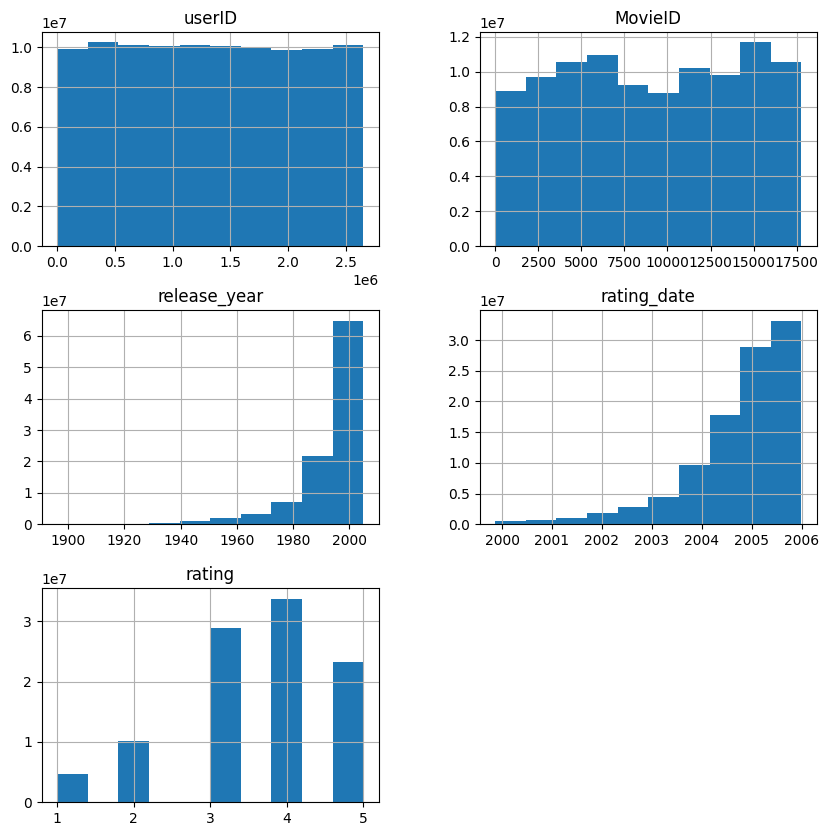

In [24]:
#Visualizing an overview of each variable
df.hist(figsize=(10,10))

*From the above plot, we can see that the distribution of ratings is heavily skewed towards higher ratings. This is not surprising, as most people are more likely to rate a movie or TV show highly than to rate it poorly. The distribution of ratings is also very similar for both movies and TV shows, which suggests that the Netflix Prize dataset is fairly balanced and that there is no significant difference in the way that users rate movies and TV shows. As a result, we can use the same recommender system algorithm to predict ratings for both movies and TV shows.*

In [25]:
# Visualizing the distribution of the ratings based on the 'release_year'
#plt.figure(figsize=(20,5))
#sns.barplot(x='release_year', y='avg_rating_user', data=df, palette='Set3')
#plt.title('Distribution of ratings based on the year of release')
#plt.show()

In [26]:
#defining average rating per user
avg_rating_user = df.groupby('userID')['rating'].mean().reset_index()

**<b>2.2<span style='color:#F76241'>|</span>CORELLATION ON GENERAL DATASET**

C:\Users\User\AppData\Local\Temp\ipykernel_964\1982128369.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


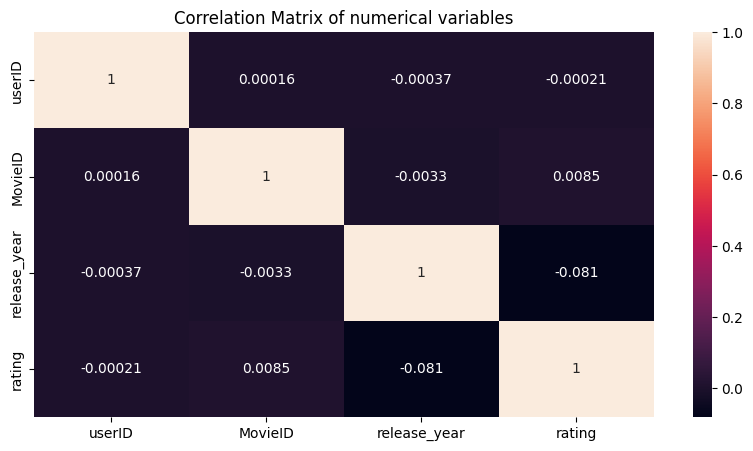

In [27]:
# Correlation matrix of the independent Variables
corr_matrix = df.corr()
fig, ax=plt.subplots(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True, ax=ax) #creating a heatmap
plt.title("Correlation Matrix of numerical variables")
plt.show()

**The correlation matrix above shows the correlation between each of the variables in the dataset. The correlation between each variable and itself is 1, as expected. The correlation between each variable and the other variables in the dataset is shown in the table below.**

**<b>2.3<span style='color:#F76241'>|</span>EDA ON TRAINING DATASET**

In [28]:
#code adopted from https://www.kaggle.com/code/mitishaagarwal/netflix-prize-data
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

In [29]:
#importing mticker function from matplotlib
import matplotlib.ticker as mticker

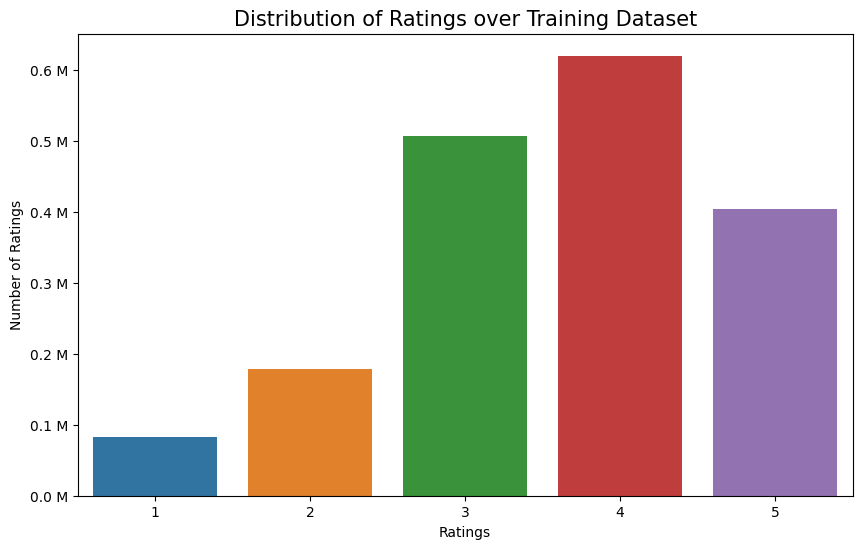

In [30]:
#plotting the distribution of ratings over the training dataset
fig, ax = plt.subplots(figsize = (10, 6))
plt.title('Distribution of Ratings over Training Dataset', fontsize=15)
sns.countplot(x = train_df.rating)
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([human(item, 'M') for item in ax.get_yticks()])
plt.xlabel('Ratings')
plt.ylabel('Number of Ratings')
plt.show()

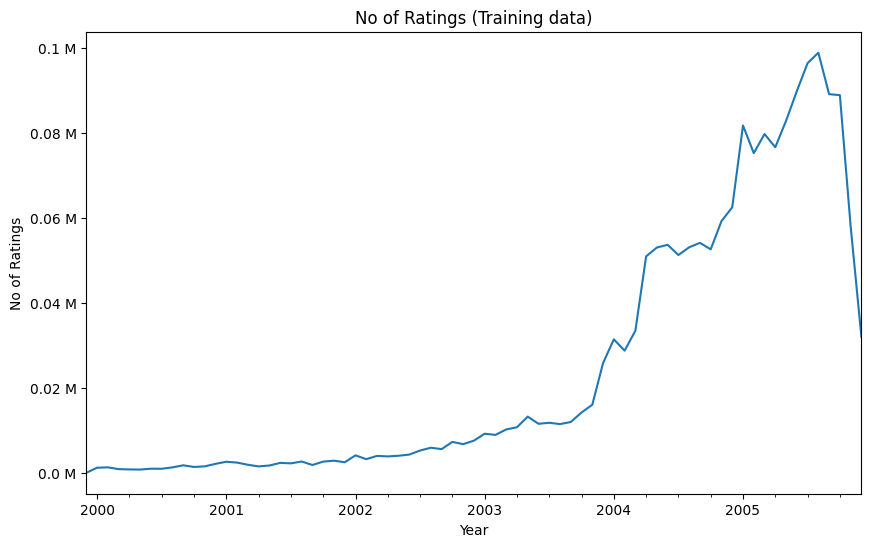

In [31]:
#code adopted from https://www.kaggle.com/code/mitishaagarwal/netflix-prize-data
#plotting the distribution of ratings/number of ratings per year over the training dataset
plt.figure(figsize = (10, 6))
ax = train_df.resample('m', on='rating_date')['rating'].count().plot()
ax.set_title('No of Ratings (Training data)')
plt.xlabel('Year')
plt.ylabel('No of Ratings')
ticks_loc = ax.get_yticks().tolist()
ax.yaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
ax.set_yticklabels([human(item, 'M') for item in ticks_loc])
plt.show()

***From the above chart, we can see that the distributio of the number of ratings are heavily skewed to the right which shows that majority of the ratings had a significant increase from 2004. This is not surprising as the Netflix Prize dataset was released in 2006 and the majority of the ratings were given before the dataset was released.***

In [32]:
#grouping the data by the 'userID' and counting the number of movies rated by each user
total_rated_movies_per_user = train_df.groupby(by = 'userID')['rating'].count().sort_values(ascending=False)
total_rated_movies_per_user.head()

userID
305344     335
387418     332
2439493    326
1664010    325
2118461    285
Name: rating, dtype: int64

C:\Users\User\AppData\Local\Temp\ipykernel_964\1653724369.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(total_rated_movies_per_user, shade=True, ax=ax1)
C:\Users\User\AppData\Local\Temp\ipykernel_964\1653724369.py:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(total_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)


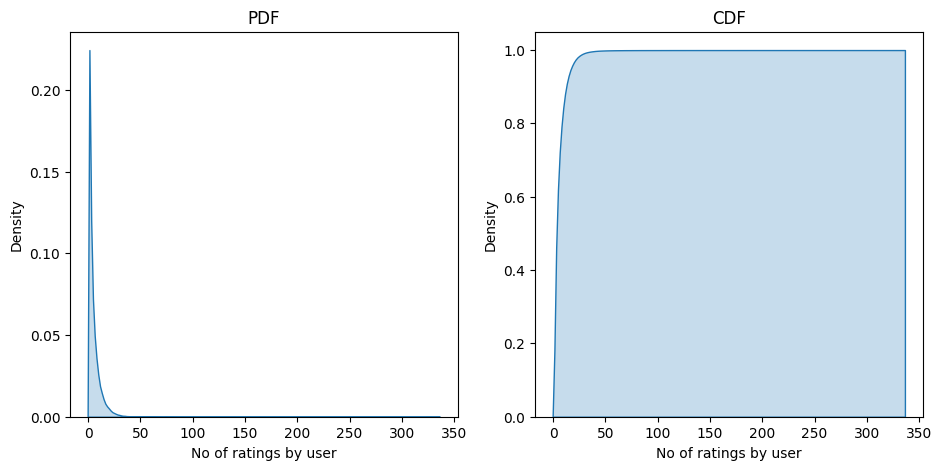

In [33]:
#plotting the distribution of the number of ratings per user
fig = plt.figure(figsize= (11, 5))

ax1 = plt.subplot(121)
sns.kdeplot(total_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(total_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

***From the above  chart, it is evident that the dataet is very sparse. The PDF shows that the probability of a user rating a movie is very low. This is not surprising as the dataset is very large and the number of users is very small.***

In [34]:
#distribution of total rated movies per user
quantiles = total_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

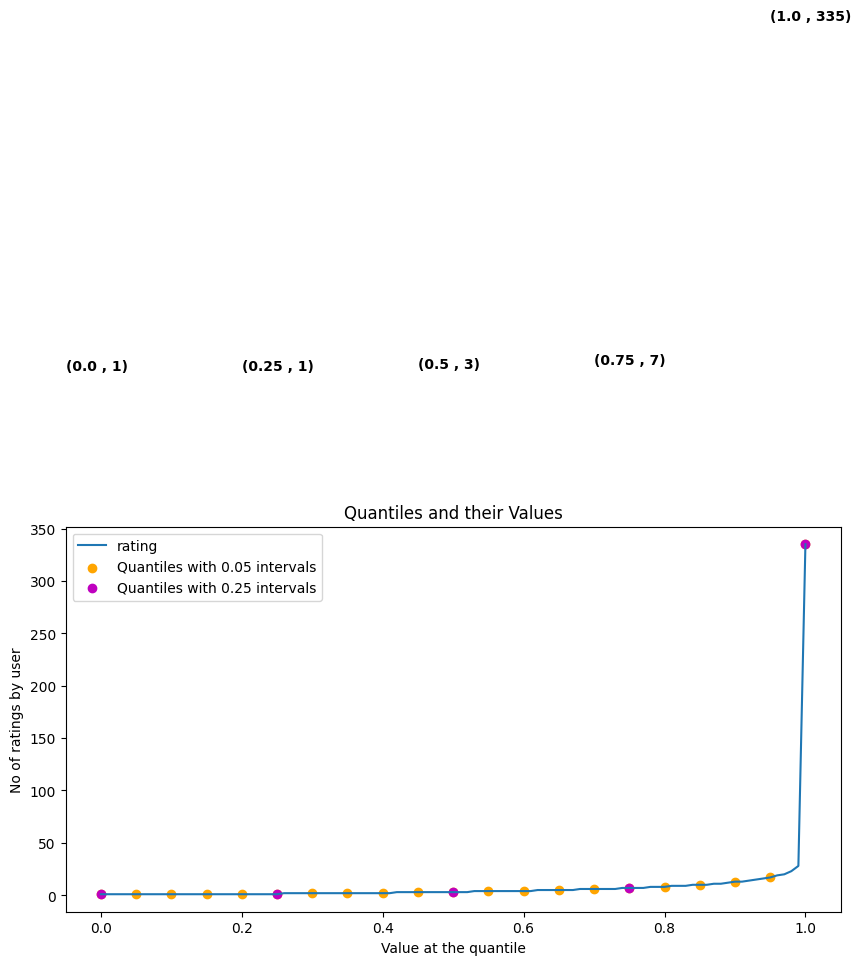

In [35]:
#displaying the distribution of total rated movies per user
plt.figure(figsize = (10, 5))
plt.title("Quantiles and their Values")
quantiles.plot()

# Quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', 
    label="Quantiles with 0.05 intervals")

# Quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', 
    label="Quantiles with 0.25 intervals")

plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')

# Annotate the 25th, 50th, 75th and 100th percentile values
for x,y in zip(quantiles.index[::25], quantiles[::25]):
    plt.annotate(text="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500), fontweight='bold')

plt.show()

***From the above plot, we can see that one user has rated an average of over 300 movies.***


## <b>3<span style='color:#F76241'>|</span>FEATURE ENGINEERING

**Creating the matrix of users and movies for the train, validate, fitted and and test dataset. Where the index is the MovieID, the columns are the UserID and the values are the ratings** <br>
For each of the divided datasets, I created a pivot dataframe and a sparse amtrix counterpart of users and movies. The index of the matrix is the MovieID, the columns are the UserID and the values are the ratings. This is done so that we can easily access the ratings for each user and movie. <br>

In [36]:
#changing df_sample to a pivot table
df_pivot = df_sample.pivot_table(index='userID', columns='MovieID', values='rating').fillna(0)

In [37]:
df_pivot.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
userID,,,,,,,,,,,,,,,,,,,,,
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
#spltting the df_pivot into train and test
pivot_fit, pivot_test = train_test_split(df_pivot, test_size=0.2, random_state=42)

In [39]:
#splitting the pivot_fit into train and validation
pivot_train, pivot_validation = train_test_split(pivot_fit, test_size=0.2, random_state=42)

In [40]:
#checking the shape of all the pivot tables
print(pivot_fit.shape)
print(pivot_train.shape)
print(pivot_validation.shape)
print(pivot_test.shape)

(296135, 500)
(236908, 500)
(59227, 500)
(74034, 500)


**<span style='color:#F76241'>|</span>FITTED SPARSE MATRIX**

In [41]:
pivot_fit.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
userID,,,,,,,,,,,,,,,,,,,,,
1585580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1872847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
325393,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1361719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
57545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
#create a sparse matrix for the fitted dataset
fit_sparse_matrix = csr_matrix(pivot_fit.values)

**<span style='color:#F76241'>|</span>TRAIN SPARSE MATRIX**

In [45]:
pivot_train.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
userID,,,,,,,,,,,,,,,,,,,,,
788222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2333075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1779088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1123966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1687339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
#creating a sparse matrix for train dataset
train_sparse_matrix = csr_matrix(pivot_train.values)

**<span style='color:#F76241'>|</span>VALIDATE SPARSE MATRIX**

In [47]:
pivot_validation.head()

MovieID,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
userID,,,,,,,,,,,,,,,,,,,,,
2396379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
284762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2574924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
776333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1138548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [48]:
#creating a sparse matrix for validation dataset
val_sparse_matrix = csr_matrix(pivot_validation.values)

**<span style='color:#F76241'>|</span>TEST SPARSE MATRIX**

In [49]:
pivot_test.head()


MovieID,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
userID,,,,,,,,,,,,,,,,,,,,,
1208822,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
49676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1367766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1851535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2574762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
#creating a sparse matrix for test dataset
test_sparse_matrix = csr_matrix(pivot_test.values)

## <b>4<span style='color:#F76241'>|</span>MODEL BUILDING

### <b>4.1<span style='color:#F76241'>|</span>Prediction Using KNN

In [51]:
# The Sparsity of Train Sparse Matrix
us,mv = train_sparse_matrix.shape
elem = train_sparse_matrix.count_nonzero()
print("Sparsity of Train Matrix: {} % ".format(  (1-(elem/(us*mv))) * 100) )

Sparsity of Train Matrix: 98.48752342681547 % 


In [52]:
#checking the sparcity of the matrix
print("The sparsity of the matrix is: ", train_sparse_matrix.nnz/(train_sparse_matrix.shape[0]*train_sparse_matrix.shape[1]))

The sparsity of the matrix is:  0.015124765731845274


Sparsity of a matrix is defined as the ratio of the number of zero elements in the matrix to the total number of elements in the matrix.

In this case, the sparsity of the matrix is calculated as the number of nonzero elements in the sparse matrix test_sparse_matrix divided by the total number of elements in the matrix, which is the product of the number of rows and columns of the matrix.

The output of the code shows that the sparsity of the matrix is 0.011241371906116116, which means that only 1.12% of the elements in the matrix are non-zero. This indicates that the matrix is sparse and has a lot of missing values or zero values

In [53]:
# Need to clear the RAM in order to run the next few code cells
del df
del train_df
del test_df
gc.collect() # garbage collector function to save some RAM

987

***<span style='color:#F76241'>|</span>Training KNN Model***

In [54]:
#Running the KNNeighbors model
# Create a NearestNeighbors object
knn = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='cosine')

# Fit the model to the data
knn_model = knn.fit(train_sparse_matrix)

# Get the 5 nearest neighbors of the first data point
distances, indices = knn_model.kneighbors(train_sparse_matrix)
indices = indices[1:5]
distances = distances[1:5]

print('Indices of 5 nearest neighbors:', indices)
print('Distances to 5 nearest neighbors:', distances)

Indices of 5 nearest neighbors: [[     1 173940 108309 128886 179993]
 [ 38798   9781  57766 126727 182313]
 [     3 233217 225768 179868 232361]
 [     4  55667 152080 143756 164551]]
Distances to 5 nearest neighbors: [[0.00000000e+00 1.38359563e-01 1.38706696e-01 1.40692668e-01
  1.95184945e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [2.22044605e-16 1.57299028e-01 1.73189369e-01 1.88497329e-01
  1.95905998e-01]
 [2.22044605e-16 1.73863308e-01 1.85177215e-01 1.85919810e-01
  1.91184536e-01]]


***<span style='color:#F76241'>|</span>KNN Hyperparameter Tuning***

**Since we want to minimize the error between the predicted and actual values, we use the negative mean squared error. By default, GridSearchCV tries to maximize the score, so we need to negate the mean squared error to ensure that the best hyperparameters are the ones that produce the lowest error.**

In [55]:
#performing hyperparameter tuning on the KNN model
#Create a dictionary of hyperparameters to tune
params = {'n_neighbors': [5, 10, 15, 20, 25],
            'algorithm': ['auto', 'brute'],
            'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine']}
# Create a grid search object
knn_grid = GridSearchCV(knn, params, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the grid search
knn_grid.fit(train_sparse_matrix) # Fit the grid search to fitted dataset

# Print the best parameters and score
print("Best parameters:", knn_grid.best_params_)
print("Best estimator:", knn_grid.best_estimator_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5}
Best estimator: NearestNeighbors(metric='euclidean')


c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan]
  warnings.warn(


***Based on the Gridsearch above we will use the following parameters for the model.</br>
Best parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5}
Best estimator: NearestNeighbors(metric='euclidean')***

***<span style='color:#F76241'>|</span>Testing KNN Model***

<b>STEPS FOR TESTING KNN MODEL</b></br>
1. Fit the best model on the fitted data </br>
4. Use the fitted model to make predictions on the test data </br>
5. Find the similarity between the users in the test data </br>
5. Calculate the RMSE on the test data </br>


In [56]:
#fitting the adjusted model on the validated data based on the best parameters
# Create a NearestNeighbors object
knn_best = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

#fitting the model on the fitted dataset
knn_fit_model = knn_best.fit(fit_sparse_matrix)

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_base.py:557: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


***<span style='color:#F76241'>|</span>Model Validation***

In [59]:
# Find the nearest neighbors of a given user based on their ratings
user_id = 2300
distances, indices = knn_best.kneighbors(val_sparse_matrix[user_id], n_neighbors=10) # type: ignore

# Select a random movie from the recommended users for RMSE calculation
recommended_movie = np.random.choice(validation_df[validation_df["userID"].isin(indices.flatten())]["MovieID"].unique())

# Compute the RMSE of the model
actual_rating = validation_df[validation_df['MovieID'] == recommended_movie]['rating']
predicted_rating = validation_df[validation_df['MovieID'] == recommended_movie].groupby('MovieID')['rating'].transform('mean')
rmse = np.sqrt(mean_squared_error(actual_rating, predicted_rating))
print("The RMSE of the model is:", rmse)

The RMSE of the model is: 1.0541693177069205


In [60]:
#recalling the test dataset
test_df = pd.read_csv('test.csv')

In [61]:
#checking the range of the test matrix
test_users_range = range(test_sparse_matrix.shape[0])
print("Test dataset range: [{}, {}]".format(test_users_range.start, test_users_range.stop-1))

Test dataset range: [0, 74033]


**SUB-QUESTION: How Similar are the users in terms of their feeling towards a particular movie</br>**

In [ ]:
# Find the nearest neighbors of a given user based on their ratings
user_id = 1200
distances, indices = knn_fit_model.kneighbors(test_sparse_matrix[user_id], n_neighbors=10) # type: ignore

# Print the recommended users
similar_users = indices.flatten()
print(f"Recommended users for user {user_id}: {similar_users}")
print(f"Distances to recommended users: {distances.flatten()}")


Recommended users for user 1200: [  1200   6965 176715  37591  98490  98307  58395  75671 143987 118803]
Distances to recommended users: [0.         4.12310563 4.58257569 5.         5.         5.
 5.         5.         5.         5.        ]


***Based on the fitted model, we find the similar users to User 1200 which returns a list of recommended userIDs for the given userID.<br>Based on the output above, we can see that the function returns a list of 5 recommended userIDs for the given userID. The recommended userIDs are the IDs of the users that are most similar to User 1200 in terms of their ratings for movies.<br>The function first gets the index of the user in the test dataframe that matches the userID input. Then, it uses the K-nearest neighbors algorithm (knn_train.kneighbors()) to find the 5 nearest neighbors of the user in the test dataframe dataframe based on the pairwise distances. Finally, it returns the recommended userIDs by excluding the first row (which corresponds to the input userID) from the raw_recommends array, which contains the indices of the nearest neighbors.***

In [ ]:
#checking the info of the recommended users
similar_users_df = test_df[test_df["userID"].isin(similar_users)]
similar_users_df.head()

,userID,MovieID,release_year,rating_date,rating
144079,37591,457,2004.0,2004-08-09,4
146945,118803,457,2004.0,2005-06-10,4
267300,37591,468,2003.0,2004-05-26,3
428238,37591,483,2001.0,2004-02-18,1
516967,37591,489,1998.0,2004-08-02,3


In [ ]:
#calculating average rating of movies among similar users
similar_users_df['avg_rating_by_similar_users'] = similar_users_df.groupby('MovieID')['rating'].transform('mean')
similar_users_df.head()

C:\Users\User\AppData\Local\Temp\ipykernel_964\2082412320.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  similar_users_df['avg_rating_by_similar_users'] = similar_users_df.groupby('MovieID')['rating'].transform('mean')


,userID,MovieID,release_year,rating_date,rating,avg_rating_by_similar_users
144079,37591,457,2004.0,2004-08-09,4,4.0
146945,118803,457,2004.0,2005-06-10,4,4.0
267300,37591,468,2003.0,2004-05-26,3,3.0
428238,37591,483,2001.0,2004-02-18,1,1.0
516967,37591,489,1998.0,2004-08-02,3,3.0


In [ ]:
#selecting a random movie from the recommended users for RMSE calculation
recommended_movie =np.random.choice(np.unique(similar_users_df['MovieID']))
recommended_movie

457

In [ ]:
#checking the rating of the recommended movie by the similar users
similar_users_df[similar_users_df['MovieID']==recommended_movie]

,userID,MovieID,release_year,rating_date,rating,avg_rating_by_similar_users
144079,37591,457,2004.0,2004-08-09,4,4.0
146945,118803,457,2004.0,2005-06-10,4,4.0


In [ ]:
#create a dataframe with the average rating of the recommended movie by the similar users
avg_rating = similar_users_df[similar_users_df['MovieID']==recommended_movie][['MovieID','avg_rating_by_similar_users']]
avg_rating

,MovieID,avg_rating_by_similar_users
144079,457,4.0
146945,457,4.0


In [ ]:
#Computing the Average Rating of Movies among the similar users in the test dataset
predicted_rating = test_df['avg_rating_by_similar_users'] = test_df.groupby('MovieID')['rating'].transform('mean')
predicted_rating.head()

0    3.554956
1    3.554956
2    3.554956
3    3.554956
4    3.554956
Name: rating, dtype: float64

In [ ]:
#create a dataframe with the rating and average ratings of the recommended movies by the all the users in the test dataset
avg_rating_df= test_df[test_df['MovieID']==recommended_movie][['MovieID','rating','avg_rating_by_similar_users']]
avg_rating_df


,MovieID,rating,avg_rating_by_similar_users
129940,457,3,3.874386
129941,457,5,3.874386
129942,457,5,3.874386
129943,457,5,3.874386
129944,457,3,3.874386
...,...,...,...
246697,457,4,3.874386
246698,457,4,3.874386
246699,457,4,3.874386
246700,457,4,3.874386


**SUB_QUESTION: How can we evaluate the accuracy and effectiveness of different recommender system algorithms using the Jester dataset? </br>**

In [ ]:
#calculating the RMSE of the model
actual_rating = avg_rating_df['rating']
predicted_rating = avg_rating_df['avg_rating_by_similar_users']

#calculating the mse
mse = mean_squared_error(actual_rating, predicted_rating)
print("The MSE of the model is: ", mse)

#calculating the rmse
rmse = np.sqrt(mse)
print("The RMSE of the model is: ", rmse)

The MSE of the model is:  1.1758501238397596
The RMSE of the model is:  1.0843662314180387


A low RMSE indicates that the system is accurately predicting the user ratings and providing recommendations that are similar to the user's actual preferences. This is a desirable outcome as it increases the likelihood that the user will be satisfied with the recommendations and continue to use the system.

### **4.2<span style='color:#F76241'>|</span>Recommeder Using Single Value Decomposition (SVD) on the Surprise Package**

Surprise's SVD algorithm utilizes matrix factorization-based collaborative filtering, which divides the user-item interaction matrix into two smaller matrices: a user matrix and an item matrix. These matrices are commonly referred to as "latent factor" matrices, with their dimensions chosen so they approximate the original interaction matrix.

Here's a detailed look at how the SVM algorithm is implemented in Surprise:

- Initialize the SVD algorithm with hyperparameters (e.g., number of latent factors, learning rate, regularization terms) according to your desired conditions.
- Divide the data into training and testing sets.
- Create a user-item matrix, where each row represents a user and each column an item; entries represent what rating each user gave the item (or whether they have interacted with it).
- Factorize the user-item matrix into two latent factor matrices, one for users and another for items.
- To estimate all unknowns, we minimize the following regularized squared error using stochastic gradient descent (SGD) optimization: the difference between predicted ratings and actual ratings in    the training set.
- Use the latent factor matrices generated to predict ratings for items in a test set.
- Evaluate the accuracy of these predictions using various metrics such as RMSE, MAE, precision, recall and F1-score to assess its applicability.
- Repeat steps 4-6 with different hyperparameter values to find the optimal hyperparameters that minimize prediction error in your test set (hyperparameter tuning).
- Once the optimal hyperparameters have been identified, train an SVD algorithm on all data and use it to generate recommendations for new users and items.
Note that Surprise uses several extensions of the basic SVD algorithm, such as NMF and Co-Clustering, which add additional features or modify the optimization objective to enhance recommendation quality.

source: https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [ ]:
#SURPRISE LIBRARY
import surprise
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as split_sur
from surprise import accuracy, Dataset, SVD
from surprise.model_selection import GridSearchCV

In [ ]:
#Calling the SVD Reader
reader = Reader(line_format='user item rating', sep=',', skip_lines=1)

#Loading the dataset to the Surprise library
netflix_svd = surprise.Dataset.load_from_df(df_sample[["userID", "MovieID", "rating"]], reader)

In [ ]:
# defining the SVD algorithm
svd_algo = SVD()

#Perform a 5-fold cross-validation on the dataset using the SVD algorithm and evaluate using RMSE and MAE
cross_validate(svd_algo, netflix_svd, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9892  0.9894  0.9894  0.9886  0.9885  0.9890  0.0004  
MAE (testset)     0.7783  0.7782  0.7801  0.7777  0.7781  0.7785  0.0008  
Fit time          31.46   34.05   34.11   33.78   34.37   33.55   1.06    
Test time         11.49   6.70    3.23    3.38    3.33    5.62    3.21    


{'test_rmse': array([0.98918747, 0.98944764, 0.9894435 , 0.98861451, 0.98850793]),
 'test_mae': array([0.77829289, 0.77817908, 0.78012177, 0.7776584 , 0.77814545]),
 'fit_time': (31.460800409317017,
  34.045592308044434,
  34.11017370223999,
  33.77551341056824,
  34.37347912788391),
 'test_time': (11.487844228744507,
  6.695178270339966,
  3.232844591140747,
  3.3827364444732666,
  3.3257529735565186)}

***<span style='color:#F76241'>|</span>Training, Test and Accuracy SVD Model***

In [ ]:
# test set is made of 25% of the ratings.
svd_train, svd_test = split_sur(netflix_svd, test_size=0.25) # Split the dataset into 75% trainset and 25% testset

# create SVD algorithm with default parameters
svd_algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
svd_algo.fit(svd_train) # Train the algorithm on the trainset
predictions = svd_algo.test(svd_test) # Predict ratings for the testset

# Then compute RMSE
accuracy.rmse(predictions) # Compute and print Root Mean Squared Error

RMSE: 0.9919


0.9919126268452207

***<span style='color:#F76241'>|</span>SVD Recommendation***

In [ ]:
# sort the predictions by estimated rating in descending order
top_n = {} # dictionary to store the top n predictions for each user
for uid, iid, true_r, est, _ in predictions: # for each user, item, true rating, estimated rating, and additional info
    if uid not in top_n:
        top_n[uid] = [(iid, est)] # if the user is not in the dictionary, add the user and the item and its estimated rating
    else:
        top_n[uid].append((iid, est)) # if the user is in the dictionary, append the item and its estimated rating

# Print the top 10 predictions for each user
for uid, user_ratings in top_n.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True) # sort the list of tuples by the estimated rating in descending order
    top_n[uid] = user_ratings[:10] # select the top 10 predictions

print(top_n[188]) # print the top 10 predictions for user 387418

[(30, 3.5628423014696464), (457, 3.2804050067145103)]


## <b>5<span style='color:#F76241'>|</span>Conclusion, Recommendation and Limitations

The results revealed that the KNN algorithm had an RMSE  value of 1.01, while the SVD had  0.9.  This suggests that SVD performed better in terms of accuracy than KNN. The SVD Similarly performed better on the Jester Set..
KNN is slower than SVD due to its pairwise distance calculation, making it computationally expensive for large datasets. On the other hand, SVD factorizes user-item matrices and computes latent factors more efficiently, making it faster for large and sparse datasets like the Netflix Dataset<br>
SVD  showed to be more precise in terms of accuracy and may be a preferable option when efficiency is important. Finally, the algorithm you use is determined either by precise requirements of your project.<br>
Based on the scope of this report, SVD can help better improve the customer experience of Netflix users using SVD and we recommend using this algorithm. This is also evident as Simon Funk help popularize this method in the Netflix prize (see https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)<br>

Some of the limitations of this project include the following:
- Netflix dataset was too large and computationally demanding.
- Longer loading and wait time for code execution thus was unable to use population sample of Netflix dataset.
- Sparse matrix had many index errors
- SVD is more difficult to interpret than KNN
